In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys
# sys.path.insert(0, '../libraries/')
# sys.path.insert(0, '../../BNP_modeling/')

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.simulation_lib as simulation_lib


import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import json 

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


# Load data

We load and plot the iris dataset

In [2]:
use_iris_data = False

In [3]:
if use_iris_data: 
    # load iris data
    dataset_name = 'iris'
    features, iris_species = utils_lib.load_data()
    dim = features.shape[1]
    n_obs = len(iris_species)    
else: 
    dim = 4
    n_obs = 500
    true_k = 4
    features, true_z = simulation_lib.simulate_data(n_obs, dim,
                true_k, separation=0.2)[0:2]
    
    iris_species = np.argmax(true_z, 1)

Text(0, 0.5, 'PC2')

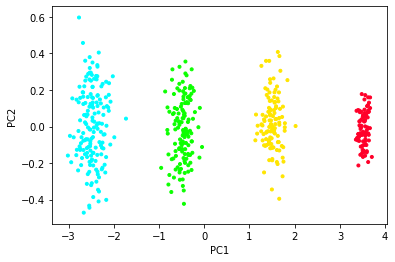

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [5]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

print(prior_params_dict)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


### Variational parameters

In [6]:
# number of clusters in variational distribution 
k_approx = 8

In [7]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [8]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [9]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

7746.96702217853

# Optimize the KL objective

### Initialize with k-means

In [10]:
run_kmeans_init = True

In [11]:
if run_kmeans_init: 
    # run a kmeans init
    n_kmeans_init = 50
    init_vb_free_params, init_vb_params_dict, init_ez = \
        utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                    n_kmeans_init = n_kmeans_init, 
                                                  seed = 45345)
else: 
    init_vb_params_dict = vb_params_paragami.random()
    init_vb_free_params = vb_params_paragami.flatten(init_vb_params_dict, free = True)

In [12]:
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
900.7086518406195


In [13]:
vb_params_dict = deepcopy(init_vb_params_dict)

In [14]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_loss = lambda x : get_vb_params_loss(features, x, prior_params_dict,
                                         gh_loc, gh_weights)


### Optimize using Newton

In [15]:
vb_opt = optimization_lib.optimize_full(get_loss, init_vb_free_params,
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
Iter 0: f = 900.70865184
Iter 1: f = 399.32104206
Iter 2: f = -264.41061238
Iter 3: f = 1718.63370110
Iter 4: f = -437.59245576
Iter 5: f = -663.14252852
Iter 6: f = -815.49419424
Iter 7: f = -717.07837668
Iter 8: f = -887.53907552
Iter 9: f = -955.63155260
Iter 10: f = -1016.89644413
Iter 11: f = -930.09262505
Iter 12: f = -1034.85876745
Iter 13: f = -1057.51862971
Iter 14: f = -1054.52557939
Iter 15: f = -1068.55383077
Iter 16: f = -1081.53435367
Iter 17: f = -1098.00424673
Iter 18: f = -1117.40794323
Iter 19: f = -1071.42606358
Iter 20: f = -1121.70519899
Iter 21: f = -1129.05650213
Iter 22: f = -1139.74971888
Iter 23: f = -1159.84334819
Iter 24: f = -1190.19220333
Iter 25: f = -1181.24302092
Iter 26: f = -1204.72402777
Iter 27: f = -1226.02297378
Iter 28: f = -1240.47497006
Iter 29: f = -1249.90200526
Iter 30: f = -1245.95066904
Iter 31: f = -1253.75273390
Iter 32: f = -1258.74801082
Iter 33: f = -1266.57913593
Iter 34: f = -1271.62760688
Iter 35: f = -1277.008037

In [16]:
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)

In [17]:
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict,
                                                    gh_loc, gh_weights)

# Check out results from Newton

In [18]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, 
                        vb_params_dict['cluster_params']['centroids'], 
                        np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))

    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

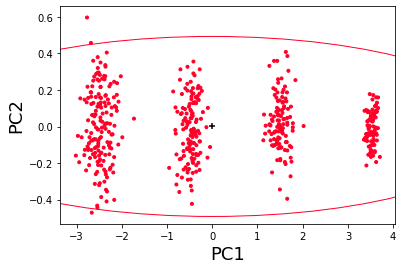

In [19]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Check out CAVI optimizer

In [20]:
vb_params_dict = deepcopy(init_vb_params_dict)

# vb_params_dict = vb_params_paragami.random()

Text(0, 0.5, 'PC2')

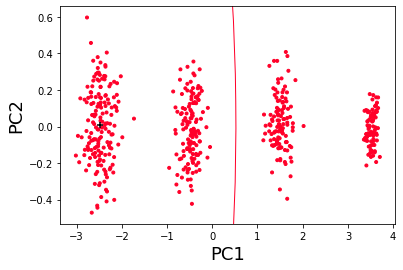

In [21]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [22]:
vb_cavi_dict, e_z_cavi, kl_vec = \
    cavi_lib.run_cavi(features, vb_params_dict,
                vb_params_paragami,
                prior_params_dict,
                gh_loc, gh_weights,
                max_iter = 100,
                tol = 1e-8,
                debug = False)


done. num iterations = 15


Text(0, 0.5, 'PC2')

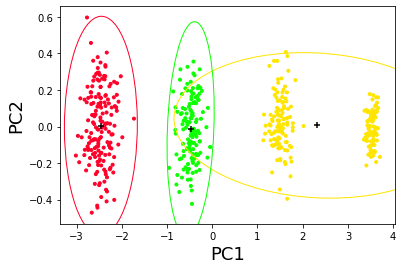

In [23]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_cavi_dict, e_z_cavi, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)
